In [1]:
import xarray as xr
import xroms
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import pandas as pd

# How to interpolate

There is a different approach for interpolation in:

* time (using `xarray interp`)
* longitude/latitude (using `xESMF`)
* depth (using `xgcm`)

In this notebook, we will demonstrate each independently as well considerations for combining the approaches.

## Load in data

Either use the first (over the internet) or second (download) option for this work. Downloading a file preemptively might be easiest since interpolation uses a lot of points to determine the appropriate calculation.

More information at in [load_data notebook](load_data.ipynb)

In [2]:
# loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
# chunks = {'ocean_time':1}
# ds = xr.open_dataset(loc, chunks=chunks)

### Helpful to have local file for this

In [3]:
url = 'http://barataria.tamu.edu:8080/thredds/fileServer/forecast_latest/txla2_his_a_latest.nc'


In [4]:
# !wget $url

In [5]:
fname = url.split('/')[-1]
chunks = {'ocean_time': 1} #{'s_rho': 1}
ds = xroms.open_netcdf(fname, chunks=chunks)

## Interpolate to...

The following section is examples of different kinds of interpolation.

### times

Interpolating in time is straight-forward because it is 1D, uncoupled from the other dimensions. So, we can just use the `xarray interp` function directly with the desired times. The result is `[ocean_time x s_rho x eta x xi]`.

Notes:
* The potentially tricky part is that chunking cannot occur in the direction of interpolation. So, here we reset the chunking and chunk in a different dimension before interpolation, then chunk back to `ocean_time` afterward.
* You can interpolate in time on the whole Dataset or a single DataArray. The example shows interpolation in time on a single DataArray.
* The interpolation times can be sequence-like, but I recommend putting them into a DataArray as follows and demonstrated in the example so that attributes are appropriately added and `cf-xarray` works afterward (also used in the other interpolation routines).
> t0s = xr.DataArray(t0s, dims='ocean_time', attrs={'axis': 'T', 'standard_name': 'time'})

Example usage for a DataArray `da`:
> da.interp(ocean_time=t0s)

In [6]:
# times to interpolate to
startdate = pd.Timestamp(ds.ocean_time[0].values)
t0s = [startdate + pd.Timedelta('30 min') + pd.Timedelta('4 hours')*i for i in range(4)]

# not necessary to change t0s to be a DataArray, but then we can add
# attributes that keep cf-xarray working
t0s = xr.DataArray(t0s, dims='ocean_time', attrs={'axis': 'T', 'standard_name': 'time'})

varin = ds.temp

# rechunk from time to vertical dimension
varin = varin.chunk({'ocean_time': -1, 's_rho': 1})

# interpolation
varout = varin.interp(ocean_time=t0s).chunk({'ocean_time':1, 's_rho': -1})

Results are demonstrated below for a single location.

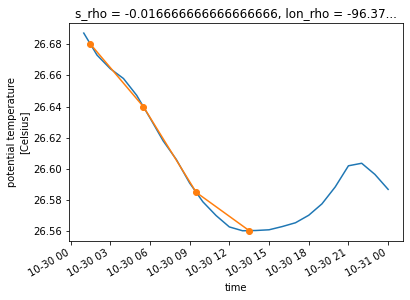

In [7]:
varin.cf.isel(Z=-1, Y=50, X=100).plot()
varout.cf.isel(Z=-1, Y=50, X=100).plot(marker='o')

### multiple lon, lat locations (1D)

Function `xroms.interpll` wraps `xESMF` so that the wrapper can take care of some niceties. It takes in longitude/latitude values and interpolates a variable onto the desired lon/lat positions correctly for a non-flat Earth. It has functionality for returning pairs of points (1D) vs. 2D arrays of points. First we demo the 1D output.

The result is dimensions `[ocean_time x s_rho x locations]`.

Notes:
* Cannot have chunks in the horizontal dimensions.
* 1D behavior is the default for `xroms.interpll` but also accessible by inputting `which='pairs'`.
* Input longitude and latitudes (below `lon0` and `lat0`) can be lists or ndarrays.

Example usage for a DataArray `da`:
> xroms.interpll(da, lon0, lat0, which='pairs')

or with `xroms` accessor:
> da.xroms.interpll(lon0, lat0, which='pairs') 

In [8]:
# use advanced indexing to pull out individual pairs of points to compare with
# rather than 2D array of lon/lat points that would occur otherwise
ie, ix = [24, 116, 121, 30], [31, 198, 439, 342]
indexer = {'xi_rho': xr.DataArray(ix, dims="pts"), 'eta_rho': xr.DataArray(ie, dims="pts")}
lat0 = ds.lat_rho.isel(indexer)
lon0 = ds.lon_rho.isel(indexer)
varin = ds.salt
varcomp = varin.isel(indexer).isel(ocean_time=0, s_rho=-1)

In [9]:
varout = xroms.interpll(varin, lon0, lat0, which='pairs')
assert np.allclose(varout.isel(ocean_time=0, s_rho=-1), varcomp)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/array/core.py:377: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Plot the interpolated surface salinity overlaid on the full field to visually check.

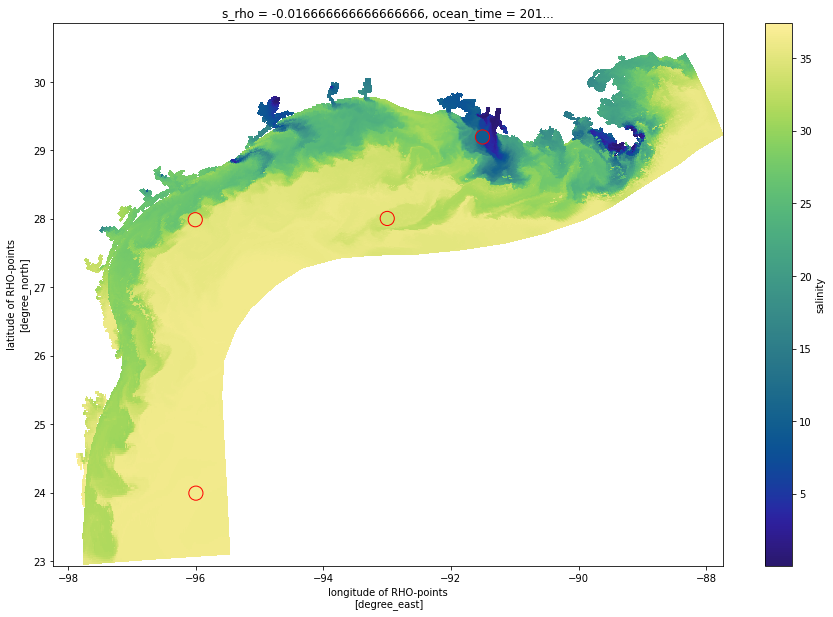

In [10]:
indexer = {'ocean_time': 0, 's_rho': -1}
salt = varin.isel(indexer)
vmin = salt.min().values; vmax = salt.max().values

fig, ax = plt.subplots(1, 1, figsize=(15,10))
salt.cf.plot.pcolormesh(x='longitude', y='latitude', infer_intervals=True, cmap=cmo.haline)
ax.scatter(lon0, lat0, c=varout.isel(indexer), s=200, edgecolor='r', vmin=vmin, vmax=vmax, cmap=cmo.haline)

### array of lon, lat locations (2D)

We can also use `xroms.interpll` to interpolate to a 2D grid of longitudes and latitudes.

Result is `[ocean_time x s_rho x lat x lon]`.

Notes:
* Cannot have chunks in the horizontal dimensions.
* 2D grids of lon0, lat0 are found by inputting `which='grid'`.
* Input longitude and latitudes (below `lon0` and `lat0`) can be lists or ndarrays.

Example usage for a DataArray `da`:
> xroms.interpll(da, lon0, lat0, which='grid')

or with `xroms` accessor:
> da.xroms.interpll(lon0, lat0, which='grid') 

In [11]:
npts = 5
lon0, lat0 = np.linspace(-95, -92, npts+1), np.linspace(28,29,npts)  # still input as 1D arrays 
LON0, LAT0 = np.meshgrid(lon0, lat0)  # for plotting
varin = ds.u

varout = xroms.interpll(varin, lon0, lat0, which='grid')

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/array/core.py:377: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Plot to visually inspect results.

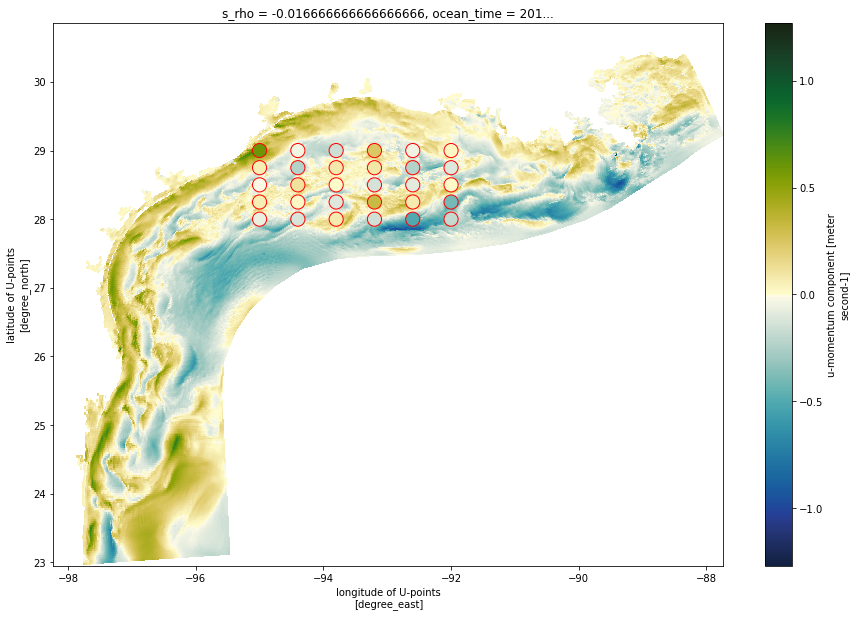

In [12]:
indexer = {'ocean_time': 0, 's_rho': -1}
vmin = abs(varin).min().values; vmax = abs(varin).max().values
vmax = max(vmin, vmax)

fig, ax = plt.subplots(1, 1, figsize=(15,10))
varin.isel(indexer).cf.plot.pcolormesh(x='longitude', y='latitude', infer_intervals=True, cmap=cmo.delta)
ax.scatter(LON0, LAT0, c=varout.isel(indexer), s=200, edgecolor='r', vmin=-vmax, vmax=vmax, cmap=cmo.delta)

### variable regridded to fixed depths

Function `xroms.zslice` wraps `xgcm grid.transform` so that the wrapper can take care of some niceties. It  interpolates a variable onto the input depths. 

The result is dimensions `[ocean_time x [z coord] x eta x xi]`, where `[z coord]` is the z coordinate used to interpolate the variable to.

Notes:
* Cannot have chunks in the vertical dimension.
* Input depths can be lists or ndarrays.
* `xgcm grid.transform` has more flexibility and functionality than is offered through `xroms.zslice`; this function focuses on just depth interpolation.
* Interpolation to fixed depths can be done using time-varying depths or with constant depths in time; do the latter to save computation time if accuracy isn't very important.


#### with z varying in time

Use the z coordinates associated with the DataArray in the interpolation.

Example usage for a DataArray `da`:
> xroms.zslice(da, depths, grid)

or with `xroms` accessor:
> da.xroms.zslice(depths) 

In [13]:
varin = ds.v
varout = xroms.isoslice(varin, np.linspace(0, -600, 20), varin.attrs['grid'])

Plot to visually inspect results:

/Users/kthyng/packages/xgcm/xgcm/transform.py:60: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


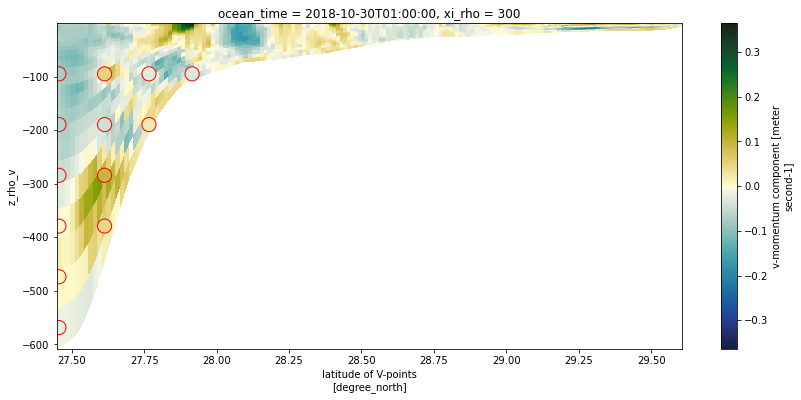

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

dss = varin.cf.isel(X=300, ocean_time=0)
dss.where(~dss.isnull(), drop=True).cf.plot(x='latitude', y='vertical', cmap=cmo.delta)

vmin = abs(dss).min().values; vmax = abs(dss).max().values
vmax = max(vmin, vmax)
toplot = varout.cf.isel(T=0, X=300, Y=slice(None,None,10), Z=slice(None,None,3))
X, Z = np.meshgrid(toplot.lat_v, toplot.z_rho_v)
ax.scatter(X, Z, c=toplot, s=200, edgecolor='r', vmin=-vmax, vmax=vmax, cmap=cmo.delta)

#### z constant in time

Input separate z coordinates `z0` for the DataArray to be interpolated to. 

Example usage for a DataArray `da`:
> xroms.zslice(da, depths, grid, z=z0)

or with `xroms` accessor:
> da.xroms.zslice(depths, z=z0) 

In [15]:
var0 = ds.v
varout0 = xroms.isoslice(var0, np.linspace(0, -600, 20), var0.attrs['grid'], iso_array=var0.z_rho_v0)

Plot the difference between the two interpolations as a point to see the difference in accounting for time-varying depths and not.

/Users/kthyng/packages/xgcm/xgcm/transform.py:60: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


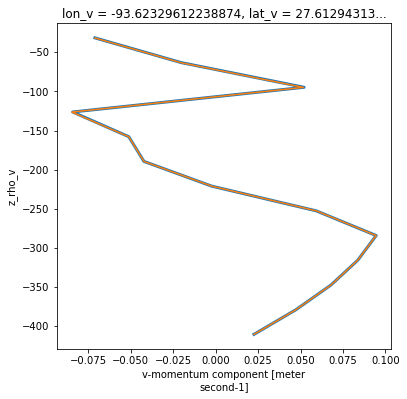

In [16]:
indexer = {'ocean_time': 0, 'Y': 10, 'X': 300}

varout.cf.isel(indexer).cf.plot(y='vertical', figsize=(6,6), lw=3)
varout0.cf.isel(indexer).cf.plot(y='vertical')

### multiple locations, depths, and times

A user can simply use multiple of these approaches one after another to interpolate in more dimensions. There are several considerations for the ordering:
    
* Downsize first

    If you are going to interpolate in time, depth, and lon/lat, consider if one of those interpolation steps will result in much less model output, and if so, do that step first. For example, if you will interpolate to 3 data locations in lon/lat but 50 vertical levels, first interpolate in lon/lat before interpolating in z to save time.

* Chunking
    
    A DataArray cannot be chunked in the dimension that is being interpolated on. So, in the previous example of interpolating first in lon/lat, the DataArray can have dask chunks in the Z and T directions when calculating the lon/lat interpolation. Then, the DataArray would need to be rechunked so that no chunks are in the Z dimension before interpolating in the Z dimension. Similarly for time. You can check chunks with `da.chunks`, specify new chunks with `da.chunk({'ocean_time': 1, 's_rho': 5})` and reset any individual dimension chunking by passing in -1, or reset all chunks for a DataArray or Dataset with `ds.chunk(-1)`.


In [17]:
varin = ds.salt
lons, lats = [-94, -93, -92], [28, 28.5, 29]
zs = np.linspace(0, -50, 20)
startdate = pd.Timestamp(ds.ocean_time[0].values)
ts = [startdate + pd.Timedelta('30 min')*i for i in range(10)]
ts = xr.DataArray(ts, dims='ocean_time', attrs={'axis': 'T', 'standard_name': 'time'})

Since there are only a few lons/lats, I will start with that:

In [18]:
varout = xroms.interpll(varin, lons, lats, which='pairs')
print(varout)

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/dask/array/core.py:377: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'salt' (ocean_time: 24, s_rho: 30, locations: 3)>
dask.array<getitem, shape=(24, 30, 3), dtype=float64, chunksize=(1, 30, 3), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-31
    lon         (locations) int64 -94 -93 -92
    lat         (locations) float64 28.0 28.5 29.0
    z_rho       (ocean_time, s_rho, locations) float64 dask.array<chunksize=(1, 30, 3), meta=np.ndarray>
  * locations   (locations) int64 0 1 2
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...
    location:       face
    field:          salinity, scalar, series
    regrid_method:  bilinear


/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.8/site-packages/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


The order of the other two steps probably doesn't matter too much in this case:

In [19]:
varout2 = varout.interp(ocean_time=ts)
varout3 = xroms.isoslice(varout2, zs, varout2.attrs['grid'])
print(varout3)

<xarray.DataArray 'salt' (ocean_time: 10, z_rho: 20, locations: 3)>
dask.array<transpose, shape=(10, 20, 3), dtype=float64, chunksize=(10, 20, 3), chunktype=numpy.ndarray>
Coordinates:
    lon         (locations) int64 -94 -93 -92
    lat         (locations) float64 28.0 28.5 29.0
  * locations   (locations) int64 0 1 2
  * ocean_time  (ocean_time) datetime64[ns] 2018-10-30T01:00:00 ... 2018-10-3...
  * z_rho       (z_rho) float64 0.0 -2.632 -5.263 -7.895 ... -44.74 -47.37 -50.0
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...
    location:       face
    field:          salinity, scalar, series
    regrid_method:  bilinear


Note that `cf-xarray` still works on this output:

In [20]:
varout3.cf.describe()

Axes:
	X: ['locations']
	Y: []
	Z: ['z_rho']
	T: ['ocean_time']

Coordinates:
	longitude: ['lon']
	latitude: ['lat']
	vertical: ['z_rho']
	time: ['ocean_time']

Cell Measures:
	area: []
	volume: []

Standard Names:
	unsupported



### Cross-section or isoslice

A cross-section or isoslice can be calculated using `xroms.isoslice`. A short example will be given here, but more examples are given in the `xroms.isoslice` docs. This is the same function used for interpolating variables to fixed depths as demonstrated earlier in this notebook.

Calculate cross-section of u-velocity along latitude of 27 degrees.

In [21]:
grid = ds.xroms.grid
lat0 = 27
varin = ds.u

In [35]:
xroms.isoslice(varin, lat0, iso_array=varin.cf['latitude'], axis='Y');